## Características para modelos de aprendizaje automatico para LDA

In [1]:
import pandas as pd
import os
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords



In [2]:
directorio_actual = os.getcwd()
print("El directorio de trabajo actual es:", directorio_actual)

El directorio de trabajo actual es: g:\Unidades compartidas\Rocío doctorado\Proyecto NLP\Códigos\LDA


In [3]:
df_lda = pd.read_csv('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/tweets_junio_LDA.csv')
df_lda.head(5)

,Unnamed: 0,retweet_count,full_text,posicion,user_name,user_id,clean_text,topico
0,2,0,En el fondo lo que les jode es nuestra liberta...,si,Luz Scarpati,2999619141,fondo jode libertad novotencontralasmujeres ab...,0
1,3,0,holla! me gustaría q ayuden a esta junta d fir...,si,gigi not hadid,3668114236,holla gustaría q ayuden junta d firmas aborto ...,0
2,6,0,Porque somos dueñas de nuestrxs cuerpas #NoVot...,si,Malena Bianca,66200186,dueñas nuestrxs cuerpas novotencontralasmujeres,0
3,9,0,#NoVotenContraLasMujeres estoy tan a la mitad ...,si,Cecilia,1005138863784976385,novotencontralasmujeres tan mitad tener postur...,0
4,15,0,@MatiasRodrigTDF @LuzScarpati Que los @Diputad...,si,Elida Rechi,1475112482,novotencontralasmujeres quesealey,0


In [4]:
print(df_lda['clean_text'][0])
df_lda['full_text'][0]

fondo jode libertad novotencontralasmujeres abortolegalya


'En el fondo lo que les jode es nuestra libertad #NoVotenContraLasMujeres #AbortoLegalYA'

In [5]:
df_lda.columns

Index(['Unnamed: 0', 'retweet_count', 'full_text', 'posicion', 'user_name',
       'user_id', 'clean_text', 'topico'],
      dtype='object')

In [6]:
lda_filtradas=df_lda[['full_text', 'posicion','topico']]
lda_filtradas.head()

,full_text,posicion,topico
0,En el fondo lo que les jode es nuestra liberta...,si,0
1,holla! me gustaría q ayuden a esta junta d fir...,si,0
2,Porque somos dueñas de nuestrxs cuerpas #NoVot...,si,0
3,#NoVotenContraLasMujeres estoy tan a la mitad ...,si,0
4,@MatiasRodrigTDF @LuzScarpati Que los @Diputad...,si,0


In [7]:
import re
import pandas as pd

# Función para limpiar los tweets
def clean_tweet(text):
    # Eliminar 'RT' al inicio del texto
    text = re.sub(r'^RT\s+', '', text)
    
    # Eliminar menciones (@usuario) y el ':' que pueda seguir
    text = re.sub(r'@\w+:\s*', '', text)
    
    # Eliminar cualquier otra mención sin el ':' y espacios innecesarios
    text = re.sub(r'@\w+', '', text)
    
    # Eliminar espacios extra generados por las eliminaciones
    text = text.strip()
    
    return text

# Aplicar la función de limpieza al DataFrame
lda_filtradas.loc[:, 'full_text_cleaned'] = lda_filtradas['full_text'].apply(clean_tweet)

# Crear nueva columna 'Question Mark': Si hay al menos un signo de interrogación (¿ o ?)
lda_filtradas.loc[:, 'Question Mark'] = lda_filtradas['full_text'].apply(lambda x: '?' in x or '¿' in x)

# Crear nueva columna 'Question Mark Count': Contar cuántos signos de interrogación hay (¿ o ?)
lda_filtradas.loc[:, 'Question Mark Count'] = lda_filtradas['full_text'].apply(lambda x: x.count('?') + x.count('¿'))

# Crear nueva columna 'Starts with Question Mark': Si el tweet empieza con al menos un signo de interrogación
lda_filtradas.loc[:, 'Starts with Question Mark'] = lda_filtradas['full_text'].apply(lambda x: x.strip().startswith('¿'))

# Crear nueva columna 'Ends with Mark Count': Si el tweet termina con al menos un signo de interrogación
lda_filtradas.loc[:, 'Ends with Mark Count'] = lda_filtradas['full_text'].apply(lambda x: x.strip().endswith('?'))

# Crear nueva columna 'Upper Ratio': Ratio de letras mayúsculas vs letras totales
lda_filtradas.loc[:, 'Upper Ratio'] = lda_filtradas['full_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Crear nueva columna 'Exclamation Mark': Si hay al menos un signo de admiración
lda_filtradas.loc[:, 'Exclamation Mark'] = lda_filtradas['full_text'].apply(lambda x: '!' in x or '¡' in x)

# Crear nueva columna 'Exclamation Mark Count': Contar cuántos signos de admiración hay
lda_filtradas.loc[:, 'Exclamation Mark Count'] = lda_filtradas['full_text'].apply(lambda x: x.count('!') + x.count('¡'))

# Crear nueva columna 'Ellipsis Occurrence': Si hay 3 o más puntos seguidos
lda_filtradas.loc[:, 'Ellipsis Occurrence'] = lda_filtradas['full_text'].apply(lambda x: '...' in x)

# Crear nueva columna 'Hashtag Presence': Presencia de hashtags
lda_filtradas.loc[:, 'Hashtag Presence'] = lda_filtradas['full_text'].apply(lambda x: bool(re.search(r'#\w+', x)))

# Crear nueva columna 'Text Length': Largo del texto sin hashtags, URLs, ni menciones de cuentas de Twitter
def limpiar_texto(texto):
    texto_sin_hashtags_urls = re.sub(r'(@\w+|http\S+|#\w+)', '', texto)  # Remueve hashtags, URLs y menciones
    return len(texto_sin_hashtags_urls.strip())

lda_filtradas.loc[:, 'Text Length'] = lda_filtradas['full_text'].apply(limpiar_texto)

# Crear nueva columna 'URL Count': Cantidad de URLs en el texto
lda_filtradas.loc[:, 'URL Count'] = lda_filtradas['full_text'].apply(lambda x: len(re.findall(r'http\S+', x)))

# Crear nueva columna 'Quotes': Si hay palabras entre comillas
lda_filtradas.loc[:, 'Quotes'] = lda_filtradas['full_text'].apply(lambda x: bool(re.search(r'["“”]', x)))

lda_filtradas


C:\Users\Usuario\AppData\Local\Temp\ipykernel_22764\1154062917.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_filtradas.loc[:, 'full_text_cleaned'] = lda_filtradas['full_text'].apply(clean_tweet)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22764\1154062917.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_filtradas.loc[:, 'Question Mark'] = lda_filtradas['full_text'].apply(lambda x: '?' in x or '¿' in x)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22764\1154062917.py:27: SettingWithCopy

,full_text,posicion,topico,full_text_cleaned,Question Mark,Question Mark Count,Starts with Question Mark,Ends with Mark Count,Upper Ratio,Exclamation Mark,Exclamation Mark Count,Ellipsis Occurrence,Hashtag Presence,Text Length,URL Count,Quotes
0,En el fondo lo que les jode es nuestra liberta...,si,0,En el fondo lo que les jode es nuestra liberta...,False,0,False,False,0.114943,False,0,False,True,47,0,False
1,holla! me gustaría q ayuden a esta junta d fir...,si,0,holla! me gustaría q ayuden a esta junta d fir...,False,0,False,False,0.076577,True,1,False,True,145,1,False
2,Porque somos dueñas de nuestrxs cuerpas #NoVot...,si,0,Porque somos dueñas de nuestrxs cuerpas #NoVot...,False,0,False,False,0.093750,False,0,False,True,39,0,False
3,#NoVotenContraLasMujeres estoy tan a la mitad ...,si,0,#NoVotenContraLasMujeres estoy tan a la mitad ...,False,0,False,False,0.029412,True,4,False,True,145,0,False
4,@MatiasRodrigTDF @LuzScarpati Que los @Diputad...,si,0,Que los #NoVotenContraLasMujeres #QueSeaLey,False,0,False,False,0.218391,False,0,False,True,7,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392959,Ojalá los médicos se organicen y marchen para ...,no,0,Ojalá los médicos se organicen y marchen para ...,False,0,False,False,0.046875,False,0,False,True,116,0,False
392960,RT @Macamil1: #ArgentinaEsProvida Quien es qui...,no,1,#ArgentinaEsProvida Quien es quién en el Senad...,False,0,False,False,0.139535,False,0,False,True,34,1,False
392961,Debe estar senil ya pobre. Avísenle que el bla...,no,1,Debe estar senil ya pobre. Avísenle que el bla...,False,0,False,False,0.109848,False,0,False,True,97,1,False
392962,RT @JuanFaerman: Aranguren y Cabrera: los prim...,no,1,Aranguren y Cabrera: los primeros abortados. #...,False,0,False,False,0.112500,False,0,False,True,49,0,False


# Eliminamos filas duplicadas

In [8]:
# Eliminar duplicados basándote en la columna 'full_text_cleaned' y conservar el primer tweet que aparezca
lda_filtradas_sin_duplicados = lda_filtradas.drop_duplicates(subset='full_text_cleaned', keep='first')
indices_sin_duplicados = lda_filtradas_sin_duplicados.index
len(indices_sin_duplicados)

169639

In [9]:
# Filtrar comunidades_filtradas usando los índices sin duplicados
lda_filtradas_filtrada = lda_filtradas.loc[indices_sin_duplicados]

lda_filtradas_filtrada

,full_text,posicion,topico,full_text_cleaned,Question Mark,Question Mark Count,Starts with Question Mark,Ends with Mark Count,Upper Ratio,Exclamation Mark,Exclamation Mark Count,Ellipsis Occurrence,Hashtag Presence,Text Length,URL Count,Quotes
0,En el fondo lo que les jode es nuestra liberta...,si,0,En el fondo lo que les jode es nuestra liberta...,False,0,False,False,0.114943,False,0,False,True,47,0,False
1,holla! me gustaría q ayuden a esta junta d fir...,si,0,holla! me gustaría q ayuden a esta junta d fir...,False,0,False,False,0.076577,True,1,False,True,145,1,False
2,Porque somos dueñas de nuestrxs cuerpas #NoVot...,si,0,Porque somos dueñas de nuestrxs cuerpas #NoVot...,False,0,False,False,0.093750,False,0,False,True,39,0,False
3,#NoVotenContraLasMujeres estoy tan a la mitad ...,si,0,#NoVotenContraLasMujeres estoy tan a la mitad ...,False,0,False,False,0.029412,True,4,False,True,145,0,False
4,@MatiasRodrigTDF @LuzScarpati Que los @Diputad...,si,0,Que los #NoVotenContraLasMujeres #QueSeaLey,False,0,False,False,0.218391,False,0,False,True,7,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392953,Exacto. #NoAlAborto #SiALaVida #SalvemosLas2V...,no,1,Exacto. #NoAlAborto #SiALaVida #SalvemosLas2V...,False,0,False,False,0.188976,False,0,False,True,7,1,False
392955,@JMKlappenbach Tal cual. #SalvemosLas2Vidas,no,1,Tal cual. #SalvemosLas2Vidas,False,0,False,False,0.162791,False,0,False,True,9,0,False
392956,@clarincom Y una vida terminada #NoAlAborto,no,1,Y una vida terminada #NoAlAborto,False,0,False,False,0.093023,False,0,False,True,20,0,False
392959,Ojalá los médicos se organicen y marchen para ...,no,0,Ojalá los médicos se organicen y marchen para ...,False,0,False,False,0.046875,False,0,False,True,116,0,False


In [10]:
lda_filtradas_filtrada['topico'].value_counts()

topico
0    111956
1     57683
Name: count, dtype: int64

In [11]:
lda_caracteristicas=lda_filtradas_filtrada.drop([ 'full_text', 'posicion', 'full_text_cleaned'], axis=1)

In [12]:
# Renombrar la columna
lda_caracteristicas.rename(columns={'topico': 'postura'}, inplace=True)

In [13]:
lda_caracteristicas.columns

Index(['postura', 'Question Mark', 'Question Mark Count',
       'Starts with Question Mark', 'Ends with Mark Count', 'Upper Ratio',
       'Exclamation Mark', 'Exclamation Mark Count', 'Ellipsis Occurrence',
       'Hashtag Presence', 'Text Length', 'URL Count', 'Quotes'],
      dtype='object')

In [14]:

lda_caracteristicas.to_csv('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/LDA_caracteristicas_baseline.csv', index=False)

## Obtencion de unigramas

Preprocesamiento de los textos para utilizarlos como entrada en los modelos de aprendizaje automático

In [24]:
# Asegúrate de tener el paquete de stopwords en español
nltk.download('stopwords')
df_preproces=pd.DataFrame()
# Inicializar el stemmer
stemmer = SnowballStemmer('spanish')
stop_words = set(stopwords.words('spanish'))

def clean_tweet(tweet):
    # Eliminar 'RT' al inicio del texto (opcional, si quieres eliminar retweets)
    # tweet = re.sub(r'^RT\s+', '', tweet)
    
    # Eliminar menciones (@usuario), URLs y caracteres no alfabéticos
    tweet = re.sub(r'@\w+|http\S+', '', tweet)  # Eliminar menciones y URLs
    
    # Reemplazar '#' con una cadena vacía para conservar las palabras de los hashtags
    tweet = re.sub(r'#(\w+)', r'\1', tweet)  # Eliminar solo el símbolo '#'
    
    # Tokenizar el tweet y aplicar el stemmer
    tokens = tweet.split()
    tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    
    return ' '.join(tokens)

# Suponiendo que tienes un DataFrame 'df' con una columna 'full_text_cleaned' y una columna 'etiqueta' (la clase)
df_preproces['cleaned_tweet'] = lda_filtradas_filtrada['full_text_cleaned'].apply(clean_tweet)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
df_preproces['cleaned_tweet']

0         en fond jod libert novotencontralasmujer abort...
1         gust q ayud junt d firm abort segur graci apru...
2           porqu dueñ nuestrxs cuerp novotencontralasmujer
3         novotencontralasmujer tan mit ten postur defin...
4                       que novotencontralasmujer quesealey
                                ...                        
392953    noalabort sialav cuidemoslasdosv nadiemen arge...
392955                                                  tal
392956                               y vid termin noalabort
392959    ojal medic organic march grit cuent los vam mi...
392961    deb senil avisenl blanc verd noalabort noalabo...
Name: cleaned_tweet, Length: 169639, dtype: object

In [26]:
df_preproces['cleaned_tweet']
df_preproces['topico']=lda_filtradas_filtrada['topico']

In [27]:
df_preproces.columns

Index(['cleaned_tweet', 'topico'], dtype='object')

In [28]:
df_preproces['topico'].value_counts()

topico
0    111956
1     57683
Name: count, dtype: int64

Modelo de clasificación: el texto se convierte en vectores numéricos usando TF-IDF, y luego se entrena una regresión logística para predecir a qué clase pertenece cada tweet

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2


# Separar las características y las etiquetas
X = df_preproces['cleaned_tweet']
y = df_preproces['topico']  # Asegúrate de que esta columna contiene las clases

# Dividir el dataset en conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline para vectorización y regresión logística
tfidf_vectorizer = TfidfVectorizer()
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

# Entrenar el modelo de regresión logística
logistic_model = LogisticRegression(multi_class='ovr', max_iter=1000)
logistic_model.fit(X_train_vectorized, y_train)

# Evaluar el modelo en el conjunto de prueba
accuracy_test = logistic_model.score(X_test_vectorized, y_test)
print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}')

# Evaluar el modelo en el conjunto de entrenamiento
accuracy_train = logistic_model.score(X_train_vectorized, y_train)
print(f'Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}')




c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy en el conjunto de prueba: 0.91
Accuracy en el conjunto de entrenamiento: 0.92


# Realizamos un análisis Chi-cuadrado para evaluar la relación entre los unigrams (palabras) y la variable objetivo en un conjunto de datos.  Filtramoa los unigrams con p-valores significativos (menores que 0.05) para identificar los unigramAs más relevantes.

In [30]:
# Calcular Chi-cuadrado
chi2_values, p_values = chi2(X_train_vectorized, y_train)
vocabulario = tfidf_vectorizer.get_feature_names_out()

# Crear un DataFrame para los resultados de Chi-cuadrado
chi2_results = pd.DataFrame({
    'unigram': vocabulario,
    'chi2': chi2_values,
    'p_value': p_values
})

# Filtrar unigramas con p-valor significativo (ejemplo: p < 0.05)
chi2_results = chi2_results[chi2_results['p_value'] < 0.05]

# Ordenar por valor Chi-cuadrado
chi2_results = chi2_results.sort_values(by='chi2', ascending=False)

# Imprimir los resultados de Chi-cuadrado
print("\nTop Unigramas por Chi-cuadrado:")
print(chi2_results.head(10))


Top Unigramas por Chi-cuadrado:
                    unigram         chi2        p_value
19574  noalabortoenargentin  4059.262232   0.000000e+00
388            abortolegaly  3290.519918   0.000000e+00
2404        argentinaesprov  3131.600297   0.000000e+00
29270                   vid  1691.817537   0.000000e+00
23637             quesealey  1409.461111  1.847203e-308
290             abortolegal  1365.714041  5.927981e-299
475           abortoseraley   612.546495  3.125238e-135
478      abortosesionhistor   566.783499  2.811872e-125
7466                 defend   422.274777   7.804002e-94
141                   abort   393.126877   1.726470e-87


# Agregamos los unigramas más significativos como columnas

In [31]:

# Extraer solo las palabras de top_20_features
top_features_words_chi = chi2_results['unigram'].tolist()
# Crear un nuevo vectorizador usando solo las palabras de top_20_features
custom_vectorizer = TfidfVectorizer(vocabulary=top_features_words_chi)

# Ajustar y transformar el DataFrame original
X_custom = custom_vectorizer.fit_transform(df_preproces['cleaned_tweet'])

# Convertir la matriz resultante a un DataFrame
X_custom_df = pd.DataFrame(X_custom.toarray(), columns=custom_vectorizer.get_feature_names_out(), index=df_preproces.index)

# Agregar las nuevas características al DataFrame original
df_unigramas_chi = pd.concat([df_preproces, X_custom_df], axis=1)

# Mostrar el DataFrame original con las nuevas columnas
print("\nDataFrame Original con Unigramas de Mayor Peso:")
df_unigramas_chi.columns


DataFrame Original con Unigramas de Mayor Peso:


Index(['cleaned_tweet', 'topico', 'noalabortoenargentin', 'abortolegaly',
       'argentinaesprov', 'vid', 'quesealey', 'abortolegal', 'abortoseraley',
       'abortosesionhistor',
       ...
       'laspibasyaeleg', 'suced', 'discapac', 'afuer', 'ellos', 'profund',
       'mate', 'ferreyr', 'triunf', 'abortoesmat'],
      dtype='object', length=891)

In [32]:
LDA_unigramas_chi=df_unigramas_chi.drop(['cleaned_tweet'], axis=1)
# Renombrar la columna
LDA_unigramas_chi.rename(columns={'topico': 'postura'}, inplace=True)
LDA_unigramas_chi.columns

Index(['postura', 'noalabortoenargentin', 'abortolegaly', 'argentinaesprov',
       'vid', 'quesealey', 'abortolegal', 'abortoseraley',
       'abortosesionhistor', 'defend',
       ...
       'laspibasyaeleg', 'suced', 'discapac', 'afuer', 'ellos', 'profund',
       'mate', 'ferreyr', 'triunf', 'abortoesmat'],
      dtype='object', length=890)

In [33]:
LDA_unigramas_chi.to_csv('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/LDA_unigramas_chi.csv', index=False)

# Extraemos los unigramas correspondienets a los  coeficientes que tuvieron mayor peso en la regresion logística

In [34]:
# Extraer los coeficientes del modelo y convertirlos en valores absolutos
coefficients = np.abs(logistic_model.coef_).flatten()

# Crear un DataFrame con los términos y sus coeficientes absolutos
coef_df = pd.DataFrame({
    'unigram': vocabulario,
    'AbsCoefficient': coefficients
})


In [35]:
coef_df

,unigram,AbsCoefficient
0,aa,0.046006
1,aaa,0.046791
2,aaaa,0.223284
3,aaaaa,0.103398
4,aaaaaa,0.106258
...,...,...
30309,𝗹𝗮𝗽𝘂𝗿𝗮𝘃𝗲𝗿𝗱𝗮𝗱,0.131908
30310,𝗺𝗮𝗿𝗰𝗵𝗮,0.105406
30311,𝗺𝗶𝗹𝗲𝘀,0.105406
30312,𝘁𝘂𝗰𝘂𝗺𝗮𝗻𝗼𝘀,0.105406


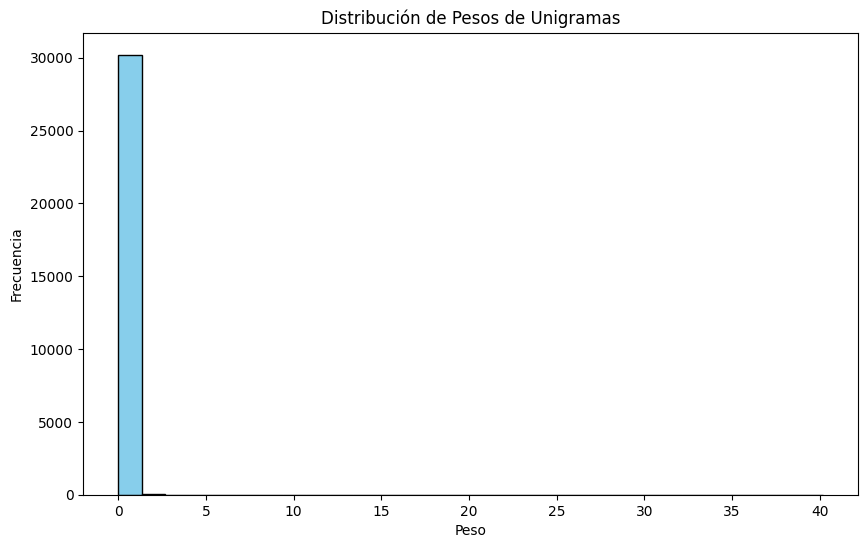

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(coefficients, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Peso')
plt.ylabel('Frecuencia')
plt.title('Distribución de Pesos de Unigramas')
plt.show()


# Filtramos los unigramas cuyos coeficientes en la regresión logística sean mayores o iguales al percentil 97.5, en términos absolutos.

In [37]:
# Calcular el percentil 95 de los valores absolutos de los pesos
threshold = np.percentile(np.abs(coefficients), 97.5)
threshold
# Filtrar unigrams cuyo peso sea mayor que el percentil 95 en valor absoluto
significant_unigrams = coef_df[np.abs(coef_df['AbsCoefficient']) >= threshold]
print(significant_unigrams)


        unigram  AbsCoefficient
70      abandon        0.919220
92        aberr        1.127249
94       abiert        1.126154
141       abort        8.068352
162    abortari        1.339328
...         ...             ...
29906       xxi        0.802166
29909        ya        0.745893
30050   yonopar        1.201162
30091     youub        0.897724
30102     yovoy        0.820991

[758 rows x 2 columns]


In [38]:
top_features = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Obtener las 10 características con mayor peso
top_20_features = top_features.head(758)

print("Las 20 características más importantes:")
print(top_20_features.head(10))

Las 20 características más importantes:
                    unigram  AbsCoefficient
388            abortolegaly       40.181416
23637             quesealey       20.825348
19574  noalabortoenargentin       14.942575
2404        argentinaesprov       12.691731
13724                   hoy       11.481043
478      abortosesionhistor       11.436951
29270                   vid       11.398179
18933                 mujer        9.788971
19566             noalabort        9.274845
290             abortolegal        9.093101


# Agregamos los unigramas como columnas para luego usarlos en modelos de clasificación

In [39]:
unigram_df = pd.DataFrame(top_20_features[['unigram', 'AbsCoefficient']])
# Extraer solo las palabras de top_20_features
top_features_words = unigram_df['unigram'].tolist()
# Crear un nuevo vectorizador usando solo las palabras de top_20_features
custom_vectorizer = TfidfVectorizer(vocabulary=top_features_words)

# Ajustar y transformar el DataFrame original
X_custom = custom_vectorizer.fit_transform(df_preproces['cleaned_tweet'])

# Convertir la matriz resultante a un DataFrame
X_custom_df = pd.DataFrame(X_custom.toarray(), columns=custom_vectorizer.get_feature_names_out(), index=df_preproces.index)

# Agregar las nuevas características al DataFrame original
df_unigramas = pd.concat([df_preproces, X_custom_df], axis=1)

# Mostrar el DataFrame original con las nuevas columnas
print("\nDataFrame Original con Unigramas de Mayor Peso:")
df_unigramas.columns



DataFrame Original con Unigramas de Mayor Peso:


Index(['cleaned_tweet', 'topico', 'abortolegaly', 'quesealey',
       'noalabortoenargentin', 'argentinaesprov', 'hoy', 'abortosesionhistor',
       'vid', 'mujer',
       ...
       'encim', 'machism', 'cac', 'provoc', 'jamas', 'quiz', 'parid', 'arma',
       'siqu', 'noalasesinat'],
      dtype='object', length=760)

In [40]:
#df_unigramas=df_unigramas.reset_index(drop=True)
df_unigramas

,cleaned_tweet,topico,abortolegaly,quesealey,noalabortoenargentin,argentinaesprov,hoy,abortosesionhistor,vid,mujer,...,encim,machism,cac,provoc,jamas,quiz,parid,arma,siqu,noalasesinat
0,en fond jod libert novotencontralasmujer abort...,0,0.197362,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,gust q ayud junt d firm abort segur graci apru...,0,0.110639,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,porqu dueñ nuestrxs cuerp novotencontralasmujer,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,novotencontralasmujer tan mit ten postur defin...,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,que novotencontralasmujer quesealey,0,0.000000,0.574037,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392953,noalabort sialav cuidemoslasdosv nadiemen arge...,1,0.000000,0.000000,0.000000,0.421294,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392955,tal,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392956,y vid termin noalabort,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.674679,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
392959,ojal medic organic march grit cuent los vam mi...,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
LDA_unigramas=df_unigramas.drop(['cleaned_tweet'], axis=1)
# Renombrar la columna
LDA_unigramas.rename(columns={'topico': 'postura'}, inplace=True)
LDA_unigramas.columns

Index(['postura', 'abortolegaly', 'quesealey', 'noalabortoenargentin',
       'argentinaesprov', 'hoy', 'abortosesionhistor', 'vid', 'mujer',
       'noalabort',
       ...
       'encim', 'machism', 'cac', 'provoc', 'jamas', 'quiz', 'parid', 'arma',
       'siqu', 'noalasesinat'],
      dtype='object', length=759)

In [42]:
LDA_unigramas.to_csv('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/LDA_unigramas.csv', index=False)

# ANALISIS DE TRIGRAMA

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import chi2  # Asegúrate de importar chi2
import pandas as pd
import numpy as np

# Separar las características y las etiquetas
X = df_preproces['cleaned_tweet']
y = df_preproces['topico']  # Asegúrate de que esta columna contiene las clases

# Dividir el dataset en conjunto de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline para vectorización y regresión logística con 3-gramas
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3, 3))  # Cambiado a 3-gramas
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

# Entrenar el modelo de regresión logística
logistic_model = LogisticRegression(multi_class='ovr', max_iter=1000)
logistic_model.fit(X_train_vectorized, y_train)

# Evaluar el modelo en el conjunto de prueba
accuracy_test = logistic_model.score(X_test_vectorized, y_test)
print(f'Accuracy en el conjunto de prueba: {accuracy_test:.2f}')

# Evaluar el modelo en el conjunto de entrenamiento
accuracy_train = logistic_model.score(X_train_vectorized, y_train)
print(f'Accuracy en el conjunto de entrenamiento: {accuracy_train:.2f}')

# Calcular Chi-cuadrado
chi2_values, p_values = chi2(X_train_vectorized, y_train)
vocabulario = tfidf_vectorizer.get_feature_names_out()

# Crear un DataFrame para los resultados de Chi-cuadrado
chi2_results = pd.DataFrame({
    'trigram': vocabulario,
    'chi2': chi2_values,
    'p_value': p_values
})

# Filtrar trigramas con p-valor significativo (ejemplo: p < 0.05)
chi2_results = chi2_results[chi2_results['p_value'] < 0.05]

# Ordenar por valor Chi-cuadrado
chi2_results = chi2_results.sort_values(by='chi2', ascending=False)

# Imprimir los resultados de Chi-cuadrado
print("\nTop Trigramas por Chi-cuadrado:")
chi2_results


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy en el conjunto de prueba: 0.71
Accuracy en el conjunto de entrenamiento: 0.75

Top Trigramas por Chi-cuadrado:


,trigram,chi2,p_value
615061,plataform adhesion virtual,162.616396,3.034069e-37
42025,adhesion virtual abortolegaly,161.796088,4.583931e-37
293581,estam plataform adhesion,161.078259,6.577586e-37
68513,aqu estam plataform,159.980505,1.142636e-36
13318,abort segur gratuit,131.497958,1.926725e-30
...,...,...,...
369810,histor argentin abortoseraley,3.851514,4.970112e-02
9244,abort mat argentinaesprov,3.846470,4.985080e-02
696289,respet vid human,3.846304,4.985574e-02
537735,ningun caus elimin,3.844757,4.990175e-02


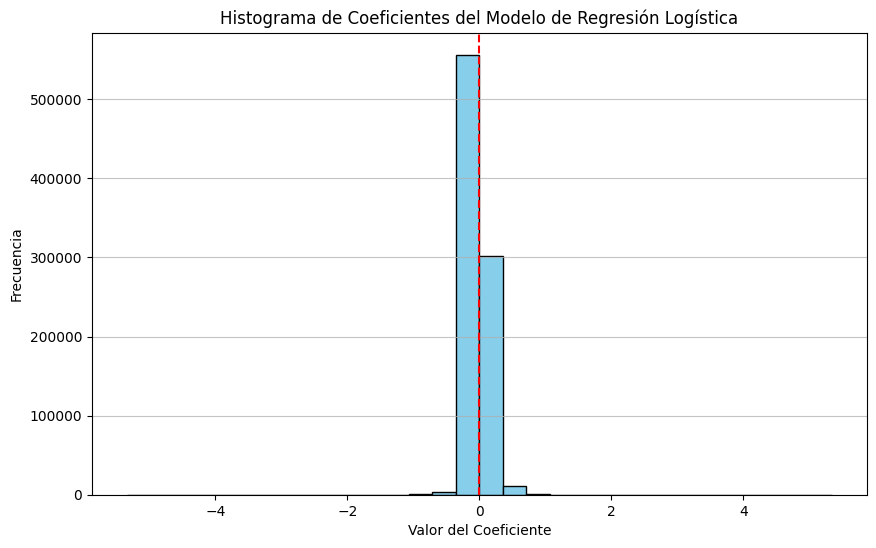

In [44]:
import matplotlib.pyplot as plt

# ... (tu código anterior para el entrenamiento del modelo)

# Obtener los coeficientes del modelo
coeficientes = logistic_model.coef_

# Dado que el modelo es multiclase (ovr), tomamos solo los coeficientes de la primera clase
# Si tienes múltiples clases, puedes iterar sobre ellas, pero aquí tomamos solo el primer conjunto
coeficientes_clase_0 = coeficientes[0]

# Crear el histograma de los coeficientes
plt.figure(figsize=(10, 6))
plt.hist(coeficientes_clase_0, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Coeficientes del Modelo de Regresión Logística')
plt.xlabel('Valor del Coeficiente')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.axvline(0, color='red', linestyle='--')  # Línea vertical en 0
plt.show()



Top 10 3-gramas más importantes por importancia relativa:
                                                   3grama  coeficiente  \
13318                                 abort segur gratuit    -5.338129   
713588  salvemoslasdosv argentinaesprov noalabortoenar...     5.336526   
863892                             vot favor abortolegaly    -4.883470   
7863                             abort legal abortolegaly    -4.519096   
13656                                      abort si abort    -4.208021   
2772                        abort clandestin abortolegaly    -4.167304   
8394                                    abort legal segur    -4.094967   
339859                                   graci defend vid     4.084742   
863886                              vot favor abortolegal     4.048795   
724499                         segur gratuit abortolegaly    -4.041358   

        importancia_relativa  
13318               0.000050  
713588              0.000050  
863892              0.000046  
78

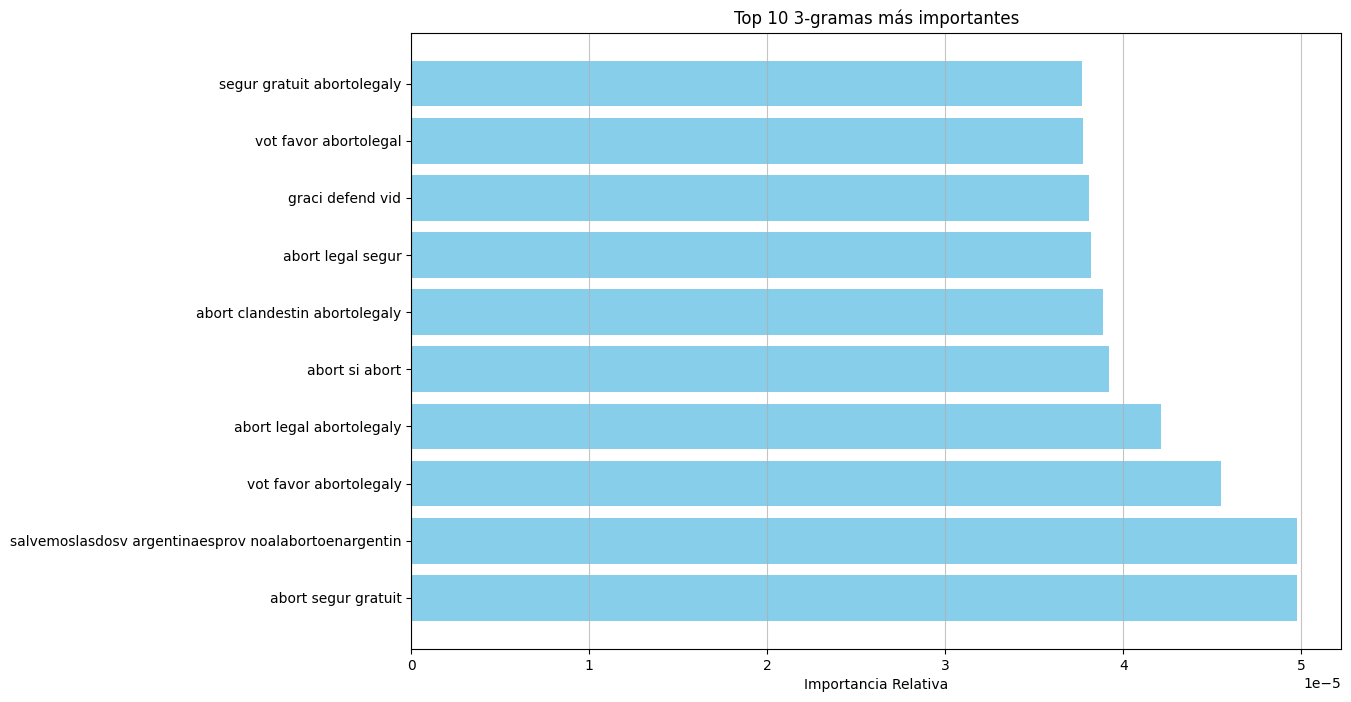

In [45]:
# Obtener los coeficientes del modelo
coeficientes = logistic_model.coef_

# Tomar los coeficientes de la primera clase (si tienes un modelo OVR)
coeficientes_clase_0 = coeficientes[0]

# Obtener los nombres de los 3-gramas
nombres_3gramas = tfidf_vectorizer.get_feature_names_out()

# Crear un DataFrame con los coeficientes y sus nombres
importancia_df = pd.DataFrame({
    '3grama': nombres_3gramas,
    'coeficiente': coeficientes_clase_0
})

# Calcular la importancia relativa
importancia_df['importancia_relativa'] = np.abs(importancia_df['coeficiente']) / np.sum(np.abs(importancia_df['coeficiente']))

# Ordenar por importancia relativa
importancia_df = importancia_df.sort_values(by='importancia_relativa', ascending=False)

# Mostrar las primeras 10 3-gramas más importantes
print("\nTop 10 3-gramas más importantes por importancia relativa:")
print(importancia_df.head(10))

# Visualizar la importancia relativa
plt.figure(figsize=(12, 8))
plt.barh(importancia_df['3grama'][:10], importancia_df['importancia_relativa'][:10], color='skyblue')
plt.xlabel('Importancia Relativa')
plt.title('Top 10 3-gramas más importantes')
plt.grid(axis='x', alpha=0.75)
plt.show()


In [46]:
# Calcular el percentil 99 de la importancia relativa
percentil_99 = importancia_df['importancia_relativa'].quantile(0.99)

# Filtrar los 3-gramas que están por encima del percentil 99
tres_gramas_importantes = importancia_df[importancia_df['importancia_relativa'] > percentil_99]

# Mostrar los resultados
print(f"\n3-gramas por encima del percentil 99 (valor del percentil: {percentil_99:.4f}):")
print(tres_gramas_importantes[['3grama', 'importancia_relativa']])



3-gramas por encima del percentil 99 (valor del percentil: 0.0000):
                                                   3grama  \
13318                                 abort segur gratuit   
713588  salvemoslasdosv argentinaesprov noalabortoenar...   
863892                             vot favor abortolegaly   
7863                             abort legal abortolegaly   
13656                                      abort si abort   
...                                                   ...   
23249   abortolegaly abortolegalessalud abortolegalseg...   
161877                                        cre deb ser   
553205         noalabortoenargentin noalabort debateabort   
353508                                       hac cos bien   
351332                                        habl si sol   

        importancia_relativa  
13318               0.000050  
713588              0.000050  
863892              0.000046  
7863                0.000042  
13656               0.000039  
...         

# AGREGAR TRIGRAMAS DE LA TABLA CHI-CUADRADO

In [47]:

# Extraer solo las palabras de top_20_features
top_features_words_chi = chi2_results['trigram'].tolist()
# Crear un nuevo vectorizador usando solo las palabras de top_20_features
custom_vectorizer = TfidfVectorizer(vocabulary=top_features_words_chi)

# Ajustar y transformar el DataFrame original
X_custom = custom_vectorizer.fit_transform(df_preproces['cleaned_tweet'])

# Convertir la matriz resultante a un DataFrame
X_custom_df = pd.DataFrame(X_custom.toarray(), columns=custom_vectorizer.get_feature_names_out(), index=df_preproces.index)

# Agregar las nuevas características al DataFrame original
df_trigrams_chi = pd.concat([df_preproces, X_custom_df], axis=1)

# Mostrar el DataFrame original con las nuevas columnas
print("\nDataFrame Original con Unigramas de Mayor Peso:")
df_trigrams_chi.columns


DataFrame Original con Unigramas de Mayor Peso:


Index(['cleaned_tweet', 'topico', 'plataform adhesion virtual',
       'adhesion virtual abortolegaly', 'estam plataform adhesion',
       'aqu estam plataform', 'abort segur gratuit',
       'sexual anticoncept abort', 'educ sexual anticoncept',
       'segur gratuit abortolegaly',
       ...
       'abortolegaly abortolegalseguroygratuit quesealey',
       'si la argentinaesprov', 'march vid no', 'tom colegi abortolegal',
       'corr riesg vid', 'histor argentin abortoseraley',
       'abort mat argentinaesprov', 'respet vid human', 'ningun caus elimin',
       'que nunc argentinaesprov'],
      dtype='object', length=1370)

In [48]:
LDA_trigramas=df_trigrams_chi.drop(['cleaned_tweet'], axis=1)
# Renombrar la columna
LDA_trigramas.rename(columns={'topico': 'postura'}, inplace=True)
LDA_trigramas.columns

Index(['postura', 'plataform adhesion virtual',
       'adhesion virtual abortolegaly', 'estam plataform adhesion',
       'aqu estam plataform', 'abort segur gratuit',
       'sexual anticoncept abort', 'educ sexual anticoncept',
       'segur gratuit abortolegaly', 'anticoncept abort legal',
       ...
       'abortolegaly abortolegalseguroygratuit quesealey',
       'si la argentinaesprov', 'march vid no', 'tom colegi abortolegal',
       'corr riesg vid', 'histor argentin abortoseraley',
       'abort mat argentinaesprov', 'respet vid human', 'ningun caus elimin',
       'que nunc argentinaesprov'],
      dtype='object', length=1369)

In [49]:
LDA_trigramas.to_csv('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/LDA_trigramas.csv', index=False)

# ANALISIS DE SENTIMIENTOS

In [50]:
lda_filtradas_filtrada['full_text_cleaned']

0         En el fondo lo que les jode es nuestra liberta...
1         holla! me gustaría q ayuden a esta junta d fir...
2         Porque somos dueñas de nuestrxs cuerpas #NoVot...
3         #NoVotenContraLasMujeres estoy tan a la mitad ...
4             Que los   #NoVotenContraLasMujeres #QueSeaLey
                                ...                        
392953    Exacto.  #NoAlAborto #SiALaVida #SalvemosLas2V...
392955                         Tal cual. #SalvemosLas2Vidas
392956                     Y una vida terminada #NoAlAborto
392959    Ojalá los médicos se organicen y marchen para ...
392961    Debe estar senil ya pobre. Avísenle que el bla...
Name: full_text_cleaned, Length: 169639, dtype: object

In [51]:
import pandas as pd
import re

# Cargar el diccionario NRC en español como un archivo CSV con columnas 'palabra' y 'sentimiento'
diccionario = pd.read_csv("G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/lexico_nrc.csv")

# Convertimos a conjuntos de palabras para agilizar la búsqueda
palabras_positivas = set(diccionario[diccionario['sentimiento'] == 'positivo']['palabra'])
palabras_negativas = set(diccionario[diccionario['sentimiento'] == 'negativo']['palabra'])

# Función para preprocesar el texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'http\S+', '', texto)  # Eliminar enlaces
    texto = re.sub(r'@\w+', '', texto)  # Eliminar menciones
    texto = re.sub(r'#\w+', '', texto)  # Eliminar hashtags
    texto = re.sub(r'[^a-záéíóúñü\s]', '', texto)  # Eliminar caracteres especiales
    return texto.split()

# Función para contar palabras positivas y negativas en un tweet
def contar_palabras_sentimiento(tweet):
    palabras = limpiar_texto(tweet)
    positivos = sum(1 for palabra in palabras if palabra in palabras_positivas)
    negativos = sum(1 for palabra in palabras if palabra in palabras_negativas)
    return pd.Series([positivos, negativos])

# Aplicar la función a cada tweet y crear las nuevas columnas en el DataFrame
lda_filtradas_filtrada[['cantidad_positivas', 'cantidad_negativas']] =lda_filtradas['full_text_cleaned'].apply(contar_palabras_sentimiento)

# Mostrar el DataFrame para verificar los resultados
print(lda_filtradas_filtrada[['full_text_cleaned', 'cantidad_positivas', 'cantidad_negativas']].head())


                                   full_text_cleaned  cantidad_positivas  \
0  En el fondo lo que les jode es nuestra liberta...                   1   
1  holla! me gustaría q ayuden a esta junta d fir...                   2   
2  Porque somos dueñas de nuestrxs cuerpas #NoVot...                   0   
3  #NoVotenContraLasMujeres estoy tan a la mitad ...                   0   
4      Que los   #NoVotenContraLasMujeres #QueSeaLey                   0   

   cantidad_negativas  
0                   1  
1                   3  
2                   0  
3                   2  
4                   0  


In [52]:

promedio_por_postura = lda_filtradas_filtrada.groupby('topico')[['cantidad_positivas', 'cantidad_negativas']].mean()
print(promedio_por_postura)


        cantidad_positivas  cantidad_negativas
topico                                        
0                 0.863259            1.451981
1                 0.892533            1.333686


In [53]:
lda_filtradas_filtrada['razon_positiva_negativa'] = lda_filtradas_filtrada['cantidad_positivas'] / (lda_filtradas_filtrada['cantidad_negativas'] + 1)
razon_por_postura = lda_filtradas_filtrada.groupby('topico')['razon_positiva_negativa'].mean()
print(razon_por_postura)


topico
0    0.407323
1    0.449082
Name: razon_positiva_negativa, dtype: float64


# Análisis de varianza (ANOVA) para comparar las medias de diferentes grupos de datos. Divide el conjunto de datos en dos categorías (positivas y negativas) basándose en la columna 'postura', y luego calcula la ANOVA por separado para las variables 'cantidad_positivas' y 'cantidad_negativas'.

In [54]:
from scipy.stats import f_oneway

grupos_positivos = [grupo['cantidad_positivas'].values for nombre, grupo in lda_filtradas_filtrada.groupby('topico')]
grupos_negativos = [grupo['cantidad_negativas'].values for nombre, grupo in lda_filtradas_filtrada.groupby('topico')]

anova_positivos = f_oneway(*grupos_positivos)
anova_negativos = f_oneway(*grupos_negativos)

print("ANOVA para palabras positivas:", anova_positivos)
print("ANOVA para palabras negativas:", anova_negativos)


ANOVA para palabras positivas: F_onewayResult(statistic=28.302804199502862, pvalue=1.0387666626227135e-07)
ANOVA para palabras negativas: F_onewayResult(statistic=198.7319017106972, pvalue=4.188661895871065e-45)


In [55]:
lda_filtradas_filtrada.columns

Index(['full_text', 'posicion', 'topico', 'full_text_cleaned', 'Question Mark',
       'Question Mark Count', 'Starts with Question Mark',
       'Ends with Mark Count', 'Upper Ratio', 'Exclamation Mark',
       'Exclamation Mark Count', 'Ellipsis Occurrence', 'Hashtag Presence',
       'Text Length', 'URL Count', 'Quotes', 'cantidad_positivas',
       'cantidad_negativas', 'razon_positiva_negativa'],
      dtype='object')

In [56]:
LDA_sentimientos=lda_filtradas_filtrada[['topico',  'cantidad_positivas',
       'cantidad_negativas', 'razon_positiva_negativa']]
# Renombrar la columna
LDA_sentimientos.rename(columns={'topico': 'postura'}, inplace=True)
LDA_sentimientos.columns

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5840\2998420014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LDA_sentimientos.rename(columns={'topico': 'postura'}, inplace=True)


Index(['postura', 'cantidad_positivas', 'cantidad_negativas',
       'razon_positiva_negativa'],
      dtype='object')

In [57]:
LDA_sentimientos.to_csv('G:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/Analisis_sentimiento_LDA.csv', index=False)

# Unimos Todas las características en dos tablas, una que contiene los unigramas elegidos sefún el coeficiente obtenido en la regresión logísitica y otro con los unigramas que se obtuvieron por l aprueba chi_cuadrado

In [58]:
lda_filtradas_filtrada=lda_filtradas_filtrada[['topico','Question Mark', 'Question Mark Count', 'Starts with Question Mark',
       'Ends with Mark Count', 'Upper Ratio', 'Exclamation Mark',
       'Exclamation Mark Count', 'Ellipsis Occurrence', 'Hashtag Presence',
       'Text Length', 'URL Count', 'Quotes', 
       'cantidad_positivas', 'cantidad_negativas', 'razon_positiva_negativa']]
df_unigramas_filtrado = df_unigramas.drop(columns=['cleaned_tweet', 'topico'])
df_unigramas_chi_filtrado = df_unigramas_chi.drop(columns=['cleaned_tweet', 'topico'])

In [59]:
import pandas as pd

# Supongamos que 'comunidades_filtradas' y 'df_unigramas' son tus DataFrames
# Asegúrate de que tengan el mismo número de filas
if lda_filtradas_filtrada.shape[0] == df_unigramas_filtrado.shape[0]:
    # Concatenar DataFrames
    df_combined = pd.concat([lda_filtradas_filtrada, df_unigramas_filtrado], axis=1)
else:
    print("Los DataFrames no tienen el mismo número de filas.")

# Verifica la forma del DataFrame resultante
print(df_combined.shape)


(169639, 774)


In [60]:
import pandas as pd

# Supongamos que 'comunidades_filtradas' y 'df_unigramas' son tus DataFrames
# Asegúrate de que tengan el mismo número de filas
if lda_filtradas_filtrada.shape[0] == df_unigramas_chi_filtrado.shape[0]:
    # Concatenar DataFrames
    df_combined_unigramas_chi = pd.concat([lda_filtradas_filtrada, df_unigramas_chi_filtrado], axis=1)
else:
    print("Los DataFrames no tienen el mismo número de filas.")

# Verifica la forma del DataFrame resultante
print(df_combined_unigramas_chi.shape)


(169639, 905)


In [53]:
df_combined.to_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/LDA_modelos.csv', index=False)

In [54]:
df_combined_unigramas_chi.to_csv('g:/Unidades compartidas/Rocío doctorado/Proyecto NLP/Datos/LDA_modelos_chi.csv', index=False)